In [ ]:
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 18.4 MB/s eta 0:00:00


In [ ]:
import getpass
import os
from google.colab import userdata


os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [ ]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

/tmp/ipython-input-3-4273151664.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [ ]:
import os
from pathlib import Path
from langchain_core.tools import tool

# Define a safe directory (relative or absolute path)
BASE_DIR = Path("/content/drive/MyDrive/AI_projects").resolve()
BASE_DIR.mkdir(exist_ok=True)

def _safe_path(filename: str) -> Path:
    """Sanitize and restrict file access to the BASE_DIR folder."""
    filepath = (BASE_DIR / filename).resolve()
    if not filepath.suffix in [".txt", ".md"]:
        raise ValueError("Only .txt or .md files are allowed.")
    if not str(filepath).startswith(str(BASE_DIR)):
        raise ValueError("Access to the specified path is not allowed.")
    return filepath

@tool
def write_file(filename: str, content: str) -> str:
    """Write content to a file (only .txt or .md allowed)."""
    path = _safe_path(filename)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)
    return f"✅ File written: {path.name}"

@tool
def read_file(filename: str) -> str:
    """Read the content of a file (only .txt or .md allowed)."""
    path = _safe_path(filename)
    if not path.exists():
        return "❌ File not found."
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def edit_file(filename: str, new_content: str) -> str:
    """Overwrite an existing document with new content."""
    path = _safe_path(filename)
    if not path.exists():
        return f"❌ File {path.name} not found."
    with open(path, "w", encoding="utf-8") as f:
        f.write(new_content)
    return f"✅ File {path.name} updated successfully."


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    filename: Annotated[str, "File name to save the outline (.txt or .md)."],
) -> Annotated[str, "Confirmation message."]:
    """
    Create an outline file from a list of points and save it in the BASE_DIR folder.
    Only .txt or .md files are allowed.
    """
    path = _safe_path(filename)
    with open(path, "w", encoding="utf-8") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"✅ Outline saved to {path.name}"


@tool
def list_files() -> str:
    """List all .txt and .md files in the workspace directory."""
    files = [f.name for f in BASE_DIR.glob("*") if f.suffix in [".txt", ".md"]]
    return "\n".join(files) if files else "📂 No documents found."

In [ ]:
from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [ ]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 2.4 MB/s eta 0:00:00


In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [ ]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

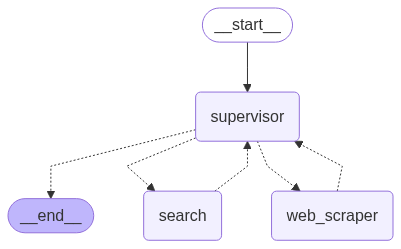

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "Summarize the page at https://fullscale.io/blog/ai-development-trends-2023/.")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'web_scraper'}}
---
{'web_scraper': {'messages': [HumanMessage(content='The blog post titled "6 Biggest AI Development Trends to Watch in 2023" on Full Scale\'s website discusses several emerging trends in artificial intelligence that are expected to have a significant impact in 2023. The key trends include:\n\n1. **Automated Machine Learning (AutoML):** This technology aims to automate the process of selecting, tuning, and optimizing machine learning models, making it easier and quicker to deploy AI applications across various industries like healthcare and finance.\n\n2. **Generative AI:** This involves AI\'s ability to create entirely new content, such as images, videos, and text, from existing data. This trend is exemplified by AI tools like OpenAI and ChatGPT that generate content for various purposes.\n\n3. **Natural Language Processing (NLP):** As NLP technology becomes more advanced, digital assistants like Siri and Alexa improve their ability to process

{'supervisor': {'next': '__end__'}}
---


In [ ]:
result = web_scraper_node({"messages": [HumanMessage(content="https://example.com")]})
print(result)

Command(update={'messages': [HumanMessage(content="It looks like you've shared a URL. How may I assist you with it? Do you need any specific information from this page?", additional_kwargs={}, response_metadata={}, name='web_scraper')]}, goto='supervisor')


In [ ]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_file, edit_file, read_file],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_file],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker"]
)

In [ ]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)


paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

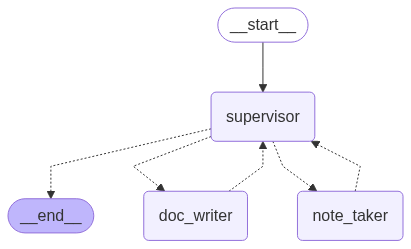

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for latest development in AI domain and then write the information to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the latest developments in the AI domain has been created and saved as "latest_developments_in_AI.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='333748e6-9e9e-41cb-b56b-b1201f5c2323')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the latest developments in the AI domain has been created and saved as "latest_developments_in_AI.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='4249e755-5e95-43db-ae70-27e5c89bd761')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The outline for the latest developments in the AI domain has been written to "latest_developments_in_AI.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='615eebe2-a32f-4900-b844-b7287dd08e7c')]}}
---


{'supervisor': {'next': '__end__'}}
---


In [ ]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [ ]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

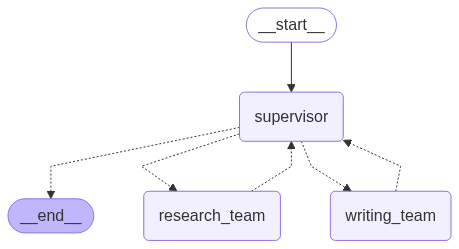

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---


{'research_team': {'messages': [HumanMessage(content="### AI Agents: Overview and Current Trends (2023)\n\nAI agents are rapidly transforming the landscape of technology and human-machine interaction. These agents function as autonomous systems that perform tasks on behalf of users, often emulating human decision-making and problem-solving abilities. Here's a brief overview of what AI agents are and the current trends related to them:\n\n#### What Are AI Agents?\n- **Definition**: AI agents are software programs that use artificial intelligence to perform specific tasks like data analysis, customer support, or personal assistance. They aim to automate processes and improve productivity.\n- **Functions**: AI agents can learn from their environments, adapt to new information, make decisions, and execute complex actions autonomously.\n\n#### Impact on Business\n- **Business Value**: AI agents contribute significantly to business efficiency by automating tasks, which not only decreases ope

{'writing_team': {'messages': [HumanMessage(content='The outline titled "AI_Agents_Overview_and_Current_Trends_2023_Outline.md" has been successfully created and saved. It includes sections on the definition and functions of AI agents, their business impact, technological integration, future trends, and industry perspectives, particularly focusing on Microsoft\'s approach.', additional_kwargs={}, response_metadata={}, name='writing_team', id='f100f2ca-ee6a-4b67-b393-f79c7b2066c8')]}}
---
{'supervisor': {'next': 'writing_team'}}
---


{'writing_team': {'messages': [HumanMessage(content="Here is a proposed structure for your document based on the outline provided:\n\n1. **Introduction**\n   - Brief overview of AI agents and their relevance in 2023.\n   \n2. **Definition of AI Agents**\n   - Detailed explanation of what AI agents are.\n   - Key characteristics and functionalities.\n   \n3. **Functions of AI Agents**\n   - How AI agents perform tasks.\n   - Examples of AI applications and use cases.\n   \n4. **Impact on Business**\n   - How AI agents influence business operations.\n   - Examples of industries most affected by AI agent integration.\n   \n5. **Technological Integration and Innovation**\n   - Recent advancements in AI technology.\n   - How AI agents are being integrated into existing systems.\n   \n6. **Future of AI Agents**\n   - Predictions and trends for the evolution of AI agents.\n   - Potential opportunities and challenges.\n   \n7. **Industry Perspectives**\n   - Insight into various industry leade

{'writing_team': {'messages': [HumanMessage(content='The document outline for "AI Agents in 2023" has been successfully created and saved as **AI_Agents_2023_Document_Structure.md**. You can now use this outline to expand and elaborate on each section according to your document\'s objectives and target audience.', additional_kwargs={}, response_metadata={}, name='writing_team', id='b66fe9cc-511f-4dd4-bb35-ed4e8a7719c2')]}}
---
{'supervisor': {'next': 'writing_team'}}
---


{'writing_team': {'messages': [HumanMessage(content='The outline for "AI Agents in 2023" includes the following sections that you can elaborate on:\n\n1. **Introduction**: \n   - Give an overview of AI agents and their growing relevance in 2023.\n\n2. **Definition of AI Agents**: \n   - Provide a detailed explanation of AI agents, highlighting key characteristics and functionalities.\n\n3. **Functions of AI Agents**: \n   - Describe how AI agents perform various tasks, using specific examples of applications and use cases.\n\n4. **Impact on Business**: \n   - Discuss how AI agents affect business operations, including examples of industries where integration has been most influential.\n\n5. **Technological Integration and Innovation**: \n   - Explore recent advancements in AI technology and discuss the integration of AI agents into existing systems.\n\n6. **Future of AI Agents**: \n   - Offer predictions and trends regarding the evolution of AI agents, along with potential opportunitie

{'writing_team': {'messages': [HumanMessage(content='The document "AI_Agents_in_2023.md" has been successfully created, elaborating on the outline provided for "AI Agents in 2023".', additional_kwargs={}, response_metadata={}, name='writing_team', id='ebaf7e72-e431-4015-a3cd-5f6fdc949aa2')]}}
---


{'supervisor': {'next': '__end__'}}
---
